In [37]:
import  polars as pl
import pyarrow.dataset as ds
from pyarrow import fs
import pandas as pd

In [2]:
s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)


In [11]:
date = "2023-03-21"
path = f"neon4cast-drivers/noaa/gefs-v12/stage1/0/{date}"
dataset = ds.dataset(path, filesystem=s3)
today_noaa = pl.scan_pyarrow_dataset(dataset)

In [117]:
df = (today_noaa
  .filter(pl.col("site_id") == "BART")
  .filter(
      (pl.col("variable") == "TMP")
         )
  .collect()
 )
# df["variable"].unique()

datetime
"datetime[μs, UTC]"
2023-03-21 00:00:00 UTC
2023-03-21 03:00:00 UTC
2023-03-21 06:00:00 UTC
2023-03-21 09:00:00 UTC
2023-03-21 12:00:00 UTC
2023-03-21 15:00:00 UTC
2023-03-21 18:00:00 UTC
2023-03-21 21:00:00 UTC
2023-03-22 00:00:00 UTC


In [116]:
# today_noaa.filter( (pl.col("variable") == "APCP") | (pl.col("variable") == "TMP") ).collect()
thin_df_wnulls = df.pivot(index = "datetime", columns = "variable", values = "prediction")
thin_df = df.pivot(index = "datetime", columns = "variable", values = "prediction").drop_nulls()
thin_df.head(10)

datetime,TMP
"datetime[μs, UTC]",f64
2023-03-21 00:00:00 UTC,-2.227118
2023-03-21 03:00:00 UTC,-4.059882
2023-03-21 06:00:00 UTC,-4.694739
2023-03-21 09:00:00 UTC,-5.266425
2023-03-21 12:00:00 UTC,-2.777747
2023-03-21 15:00:00 UTC,2.53103
2023-03-21 18:00:00 UTC,4.445459
2023-03-21 21:00:00 UTC,3.60708
2023-03-22 00:00:00 UTC,-0.925391


In [76]:
thin_df_wdate = thin_df.with_columns(pl.col("datetime").cast(pl.Date).alias("date"))

In [86]:
date_averaged_df = (
    thin_df_wdate
    .groupby("date")
    .agg(
        [
            pl.col("TMP").mean().alias("TMP_daymean"),
            pl.col("APCP").mean().alias("APCP_daymean")
        ]
    )
    .sort("date")
)
date_averaged_df.head(15)

date,TMP_daymean,APCP_daymean
date,f64,f64
2023-03-21,-1.313536,0.1
2023-03-22,-1.262198,0.01
2023-03-23,0.858568,1.175
2023-03-24,1.504335,0.1225
2023-03-25,-2.077788,0.8025
2023-03-26,-1.22531,1.705
2023-03-27,-1.065504,0.2475
2023-03-28,-1.62847,0.1575
2023-03-29,-1.34632,3.8625


In [87]:
type(date_averaged_df)

polars.dataframe.frame.DataFrame

In [97]:
import darts

pandas_date_averaged = date_averaged_df.to_pandas()
pandas_date_averaged["date"] = pd.to_datetime(pandas_date_averaged["date"])
pandas_date_averaged["date"][0]

NOAA_covariates = darts.TimeSeries.from_dataframe(
    pandas_date_averaged,
    time_col = "date",
    freq = "D",
)

In [104]:
NOAA_covariates_pd = NOAA_covariates.pd_dataframe()
NOAA_covariates_pd.head(10)

component,TMP_daymean,APCP_daymean
date,,
2023-03-21,-1.313536,0.1000
2023-03-22,-1.262198,0.0100
2023-03-23,0.858568,1.1750
2023-03-24,1.504335,0.1225
2023-03-25,-2.077788,0.8025
2023-03-26,-1.225310,1.7050
2023-03-27,-1.065504,0.2475
2023-03-28,-1.628470,0.1575
2023-03-29,-1.346320,3.8625


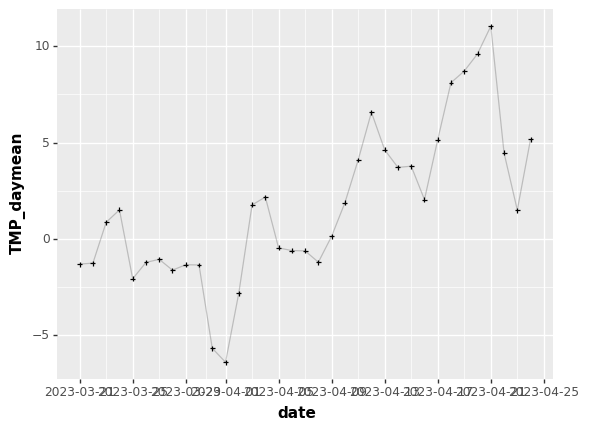

<ggplot: (8745612720291)>

In [113]:
import plotnine as gg

(
    gg.ggplot(pandas_date_averaged, gg.aes("date", "TMP_daymean"))
    + gg.geom_line(alpha=0.2) + gg.geom_point(shape="+")
)


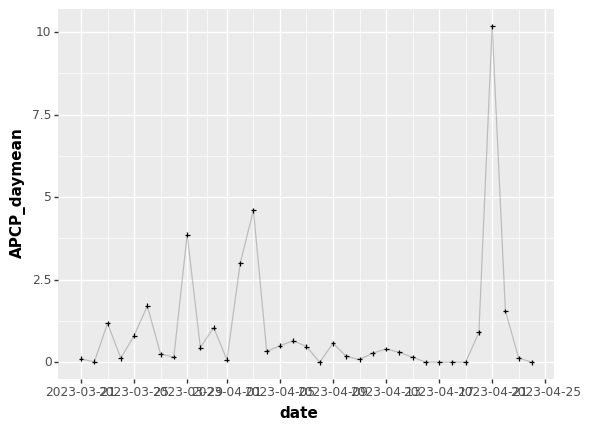

<ggplot: (8745612641037)>

In [114]:
(
    gg.ggplot(pandas_date_averaged, gg.aes("date", "APCP_daymean"))
    + gg.geom_line(alpha=0.2) + gg.geom_point(shape="+")
)